# 1.0 Data preparation

In [1]:
from google.colab import drive
import pandas as pd
import ast
import numpy as np

drive.mount('/content/drive')
drive_path = 'drive/My Drive/'

Mounted at /content/drive


**TMDB dataset updated daily**

Link: https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies/data

In [2]:
cols_to_use = ['title', 'genres', 'original_language', 'overview', 'popularity', 'release_date','tagline', 'credits', 'keywords',"vote_average"]
movies = pd.read_csv(drive_path + 'data/tmdb/movies.csv', usecols=cols_to_use)

Text(0.5, 1.0, 'Missing values for each column')

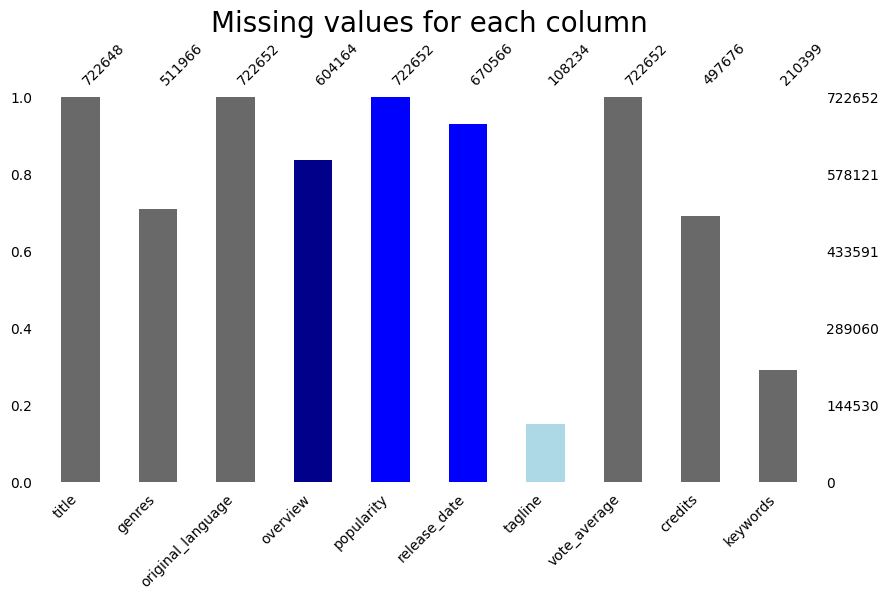

In [3]:
import missingno
import matplotlib.pyplot as plt
color= ['dimgrey','dimgrey','dimgrey','darkblue','blue','blue','lightblue','dimgrey','dimgrey','dimgrey','dimgrey','dimgrey']
missingno.bar(movies,fontsize=10,color=color,figsize=(10,5))
plt.title('Missing values for each column',fontsize=20)

# 2.0 Data Visualization and Analysis

# 3.0 Recommendation system

**Cosine similarity**

This part is without out word embeddings and only 10 000 rows of the total 700 000 rows.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tqdm import tqdm
from time import sleep

movies = movies.fillna('').astype(str)

movies['bag_of_words'] = movies.apply(' '.join, axis=1)

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(tqdm(movies['bag_of_words'][:10000]))
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

recommendations = get_recommendations('Braveheart')

recommendations

100%|██████████| 10000/10000 [00:02<00:00, 4244.77it/s]


3260                                      Braveheart
8496                                Robert the Bruce
4419                               Gangs of New York
9424                                         Rob Roy
8004                                    Far and Away
6117                                     Outlaw King
263     Harry Potter and the Deathly Hallows: Part 1
5543                                A Bridge Too Far
2727                               Kingdom of Heaven
6835                                    Black Beauty
9337                                       The Saint
Name: title, dtype: object

In [5]:
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import gensim.downloader as api

pd.read_csv(drive_path + 'data/tmdb/movies.csv', usecols=cols_to_use)

# Preprocessing function
nltk.download('punkt')
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return word_tokenize(text)

# Preprocess descriptions
movies['processed_overview'] = movies['overview'].apply(preprocess)

# Loading a GloVe model
model = api.load("glove-wiki-gigaword-50")  # This model has 50-dimensional vectors

# Function to convert description to GloVe vector
def description_to_vector(description):
    vectors = [model[word] for word in description if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Adjust the size to the model's vector size

# Convert descriptions to GloVe vectors
movies['overview_vector'] = movies['processed_overview'].apply(description_to_vector)

# Perform PCA to reduce vector dimensions
pca = PCA(n_components=50)  # Adjust the number of components as needed
overview_vectors = pca.fit_transform(list(movies['overview_vector']))

# Compute cosine similarity
cosine_sim_w2v = cosine_similarity(overview_vectors)

# Function to get movie recommendations based on similarity of descriptions
def get_recommendations_w2v(title, cosine_sim=cosine_sim_w2v):
    # Get the index of the movie that matches the title
    idx = movies[movies['title'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

# Test the function with a movie
test_movie = 'The Dark Knight'
recommendations_w2v = get_recommendations_w2v(test_movie)
print(f"Recommendations for {test_movie}:\n", recommendations_w2v)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[==================================================] 100.0% 66.0/66.0MB downloaded
